## Import all of our dependencies

In [1]:
# OpenAI Gym stuff
import gym # Gives us a basic environment to work with reninforcement learning environments
import gym_anytrading # Gives us a specific trading environment

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv # A vectorized wrapper that we will use to wrap our trading env inin orderr to pass it to stable base lines
from stable_baselines3 import A2C # The actual algorithm we will be using
                                  # There is other algos like PPO1, PPO2, TD3 ...
from stable_baselines3.common.callbacks import BaseCallback
from sklearn.metrics import explained_variance_score

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 

# Typing
from typing import Tuple

## Bring Marketwatch GME data

In [2]:
# Reading data and visualize the 5 first rows
df = pd.read_csv('data/gmedata.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,03/12/2021,275.00,295.50,262.27,264.5,"25,845,900"
1,03/11/2021,241.64,281.50,232.60,260.0,"28,312,490"
2,03/10/2021,269.43,348.50,172.00,265.0,"71,570,570"
3,03/09/2021,217.71,249.85,208.51,246.9,"39,099,328"
4,03/08/2021,154.89,210.87,146.10,194.5,"63,565,621"


In [3]:
# Checking the pandas data frame dtypes to make any necessary changes to the df types to met the gym_anytrading requirements
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

In [4]:
# Converting the date column to datetime type
df['Date'] = pd.to_datetime(df['Date']) 

# Setting the Date column as index (gym_anytrading requirement)
df.set_index('Date', inplace=True)

# Add df.sort_index() so the data isn't reversed. The model is training and predicting on reversed data. Gym-anytrading does not automatically sort by the date index.
df.sort_index(ascending=True, inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-03-16,3.93,4.57,3.90,4.37,"4,866,696"
2020-03-17,4.40,4.65,4.11,4.23,"3,562,210"
2020-03-18,4.10,4.25,3.50,3.77,"3,651,709"
2020-03-19,3.71,4.20,3.55,4.19,"5,039,539"
2020-03-20,4.08,4.08,3.65,3.76,"7,722,194"


In [5]:
# Creating the trading environment
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features

class MyStocksEnv(StocksEnv):
    _process_data = my_process_data # Helps to access the features from outide the trading environment
    
env = StocksEnv(df=df, window_size=5, frame_bound=(5,100))  # This env is where our ML is going to learn how to trade
                                                            # Including the first 100 time steps starting from the 5th time step
                                                            # frame_bound[0] >= window_size
                                                            # windows_size: refers to how many previous time steps our trading bot is going to have as refrence data 
                                                            # for when it goes and makes its next trade


## Build Environment

info {'total_reward': 1.8599998950958252, 'total_profit': 1.1841607149438245, 'position': <Positions.Short: 0>}


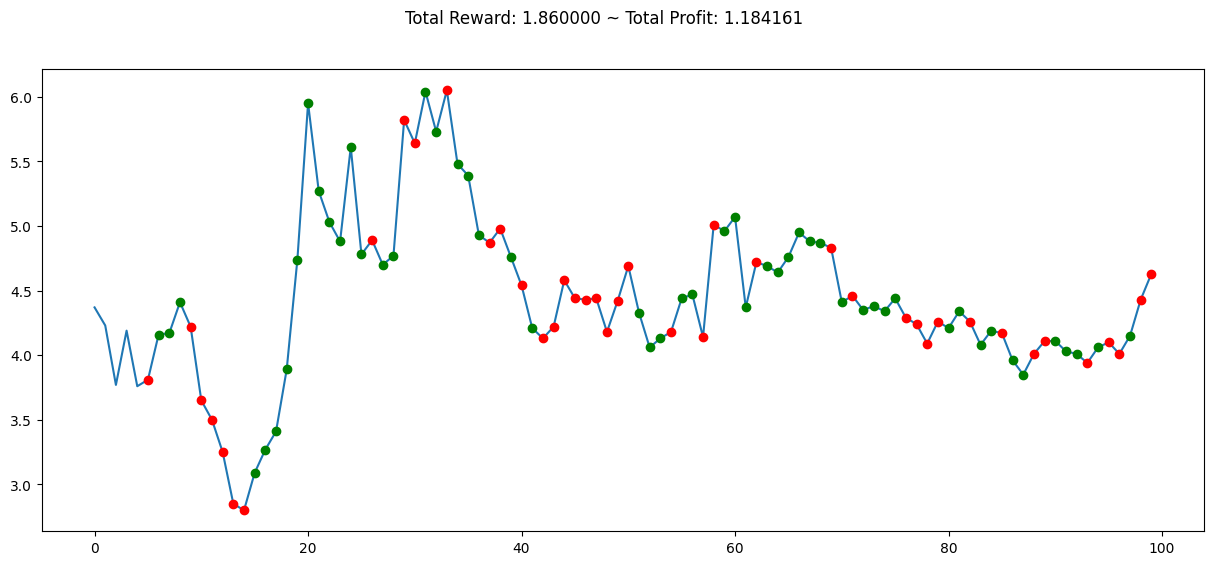

In [6]:
state = env.reset() # Getting the initial state
while True: 
    action = env.action_space.sample() # Randomy buying or selling GME shares 
    n_state, reward, done, truncated, info = env.step(action)  # Taking random steps in the environment, taking the action and applying it to the environment
    if done or truncated: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all() # Renders all the trades that happend in our environment
plt.show()

## Build Environment and Train using Stable Base Lines 3

In [7]:
# Wrapping the env in a vectorized env
env_maker = lambda: StocksEnv(df=df, window_size=5, frame_bound=(5,100))
env = DummyVecEnv([env_maker])

In [8]:
from stable_baselines3.common.callbacks import BaseCallback
from sklearn.metrics import explained_variance_score
import numpy as np

class StopTrainingOnHighExplainedVariance(BaseCallback):
    """
    Custom callback that stops training when the explained variance is near one.
    """
    def __init__(self, check_freq: int, verbose=0):
        super(StopTrainingOnHighExplainedVariance, self).__init__(verbose)
        self.check_freq = check_freq
        self.explained_variance_threshold = 0.9

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.
        """
        if self.n_calls % self.check_freq == 0:
            # Get the current rewards and predicted values
            rewards = np.array(self.model.rollout_buffer.rewards)
            values = np.array(self.model.rollout_buffer.values).flatten()
            # Compute the explained variance
            explained_variance = explained_variance_score(rewards, values)
            # Stop training if the explained variance is above the threshold
            if explained_variance >= self.explained_variance_threshold:
                print(f"Stopping training because explained variance {explained_variance} is above threshold {self.explained_variance_threshold}")
                return False
        return True

# Create the callback
# check_freq = 1000
check_freq = 10
callback = StopTrainingOnHighExplainedVariance(check_freq=check_freq)

# In this code, check_freq is the number of steps between each computation of the explained variance. 
# It's set to 1000, which means the explained variance is computed every 1000 steps. 
# This can reduce the computational overhead of the callback, especially for large environments or long training runs

In [9]:
# Training the model
model = A2C('MlpPolicy', env, verbose=1) # specifying the policy: MlpLstmPolicy multi layer perceptron lstm policy (we will be using a deep neural network which has a lstm layer)
                                         # lstm layer allow the neural network to keep context
                                             
# (optionally we can configure a callback function to stop the model when we hit a certain level of accuracy)
model.learn(total_timesteps=1000000, callback=callback) # Training the model for 1 million time steps
                                     # We need to pay attention to explained variance value we need it to be as close to 1 as possible
                                     # The closer to one the more the model begun to learn the difference variances in the data and now start to understand the patterns in the data.
                                     

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 553      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.214   |
|    explained_variance | -1.06    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00145 |
|    value_loss         | 0.00163  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 566      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.24    |
|    explained_variance | -332     |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.00142 |
|    value_loss      

In this example, callback=callback passes the custom callback to the learn() method. The model will stop training when the explained variance is near one.
Remember to replace 'env' with your environment and adjust the check_freq and explained_variance_threshold parameters as needed for your specific use case.

## Evaluation

In [10]:
env = StocksEnv(df=df, window_size=5, frame_bound=(120, 140))
obs, info = env.reset()

print("reset oberservation shape", obs.shape)
print("obs", obs)
print("------")

while True: 
    obs = obs[np.newaxis, ...]   
    action, _states = model.predict(obs)
    obs, rewards, done, truncated,  info = env.step(action)
 
    print("reset oberservation shape", obs.shape)
    print("obs", obs)
    print("------")
    
    if done or truncated:
        print("info", info)
        break

reset oberservation shape (5, 2)
obs [[5.39 0.14]
 [6.68 1.29]
 [7.65 0.97]
 [7.71 0.06]
 [7.82 0.11]]
------
reset oberservation shape (5, 2)
obs [[ 6.68  1.29]
 [ 7.65  0.97]
 [ 7.71  0.06]
 [ 7.82  0.11]
 [ 7.65 -0.17]]
------
reset oberservation shape (5, 2)
obs [[ 7.65  0.97]
 [ 7.71  0.06]
 [ 7.82  0.11]
 [ 7.65 -0.17]
 [ 7.7   0.05]]
------
reset oberservation shape (5, 2)
obs [[ 7.71  0.06]
 [ 7.82  0.11]
 [ 7.65 -0.17]
 [ 7.7   0.05]
 [ 7.35 -0.35]]
------
reset oberservation shape (5, 2)
obs [[ 7.82  0.11]
 [ 7.65 -0.17]
 [ 7.7   0.05]
 [ 7.35 -0.35]
 [ 6.23 -1.12]]
------
reset oberservation shape (5, 2)
obs [[ 7.65 -0.17]
 [ 7.7   0.05]
 [ 7.35 -0.35]
 [ 6.23 -1.12]
 [ 6.09 -0.14]]
------
reset oberservation shape (5, 2)
obs [[ 7.7   0.05]
 [ 7.35 -0.35]
 [ 6.23 -1.12]
 [ 6.09 -0.14]
 [ 6.91  0.82]]
------
reset oberservation shape (5, 2)
obs [[ 7.35 -0.35]
 [ 6.23 -1.12]
 [ 6.09 -0.14]
 [ 6.91  0.82]
 [ 7.09  0.18]]
------
reset oberservation shape (5, 2)
obs [[ 6.23 -1.12

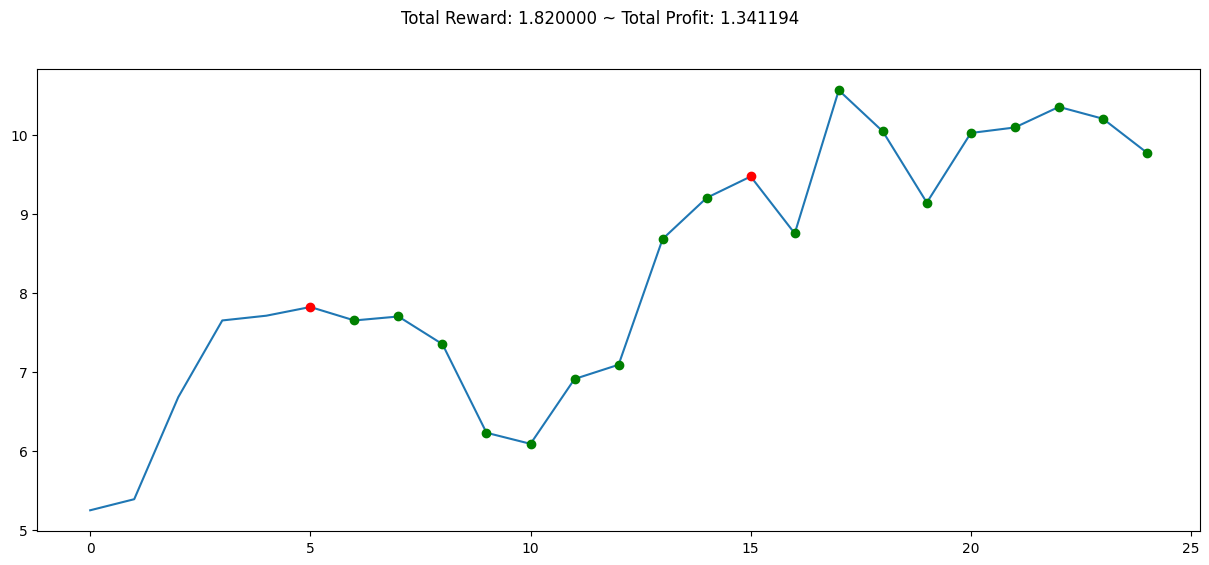

In [11]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

- We can create new signals
- Add additional data
- Train for longer
- ...